In [1]:
from typing import Dict
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from plot import plot_hbar_groups, plot_hlines, plot_stack

In [2]:
COLORS = {
    "chainguard": "blue",
    "rapidfort": "firebrick",
    "alpine": "pink",
    "original": "gray"
}

def format_df(df: pd.DataFrame, column: str) -> Dict:
    registries = df["registry_type"].unique()
    images = df["image_type"].unique()
    members = {r: [] for r in registries}

    for reg in registries:
        for img in images:
            tmask = df["registry_type"] == reg
            imask = df["image_type"] == img
            filtered = df[tmask & imask][column]
            if filtered.shape[0] == 0:
                val = 0
            else:
                val = filtered.iloc[0]
            members[reg].append(val)
    
    return members, images

def plot_df(df: pd.DataFrame, column: str):
    _, ax = plt.subplots(figsize=(5,5))
    members, groups = format_df(df, column)
    plot_stack(ax, members, "original", groups, COLORS)

In [3]:
# Image size by registry
sz_df = pd.read_csv(os.path.join("data", "out", "metadata.csv"))
sz_df["image_size"] = sz_df["image_size"] / 1000000

comps_df = pd.read_csv(os.path.join("data", "out", "components.csv"))
comps_df = comps_df.drop(["type"], axis=1) \
                    .groupby(["registry_type", "image_type"]) \
                    .count() \
                    .reset_index() \
                    .rename(columns={"component_name": "n_components"})

vulns_df = pd.read_csv(os.path.join("data", "out", "vulns.csv"))
vulns_df = vulns_df.drop(["type"], axis=1) \
                   .groupby(["registry_type", "image_type"]) \
                   .count() \
                   .reset_index() \
                   .rename(columns={"severity": "n_vulns"})

df = vulns_df.merge(sz_df, how="left",
                    on=["registry_type", "image_type"]) \
             .merge(comps_df, how="left",
                    on=["registry_type", "image_type"])

df["vpm"] = df["n_vulns"] / df["image_size"]
df["vpc"] = df["n_vulns"] / df["n_components"]

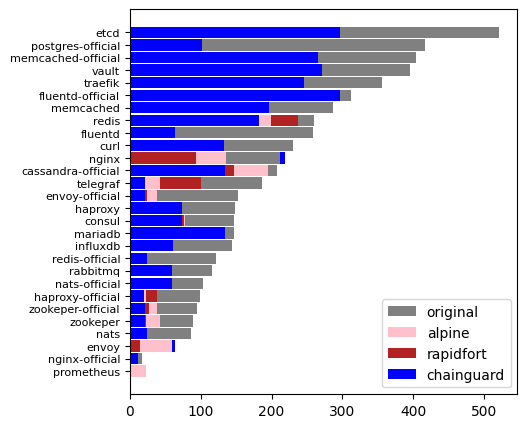

In [4]:
# Figure 1: Image Size by Registry

#sz_df.groupby("registry_type").describe()

plot_df(sz_df[size_df["registry_type" != "alpine"]], "image_size")

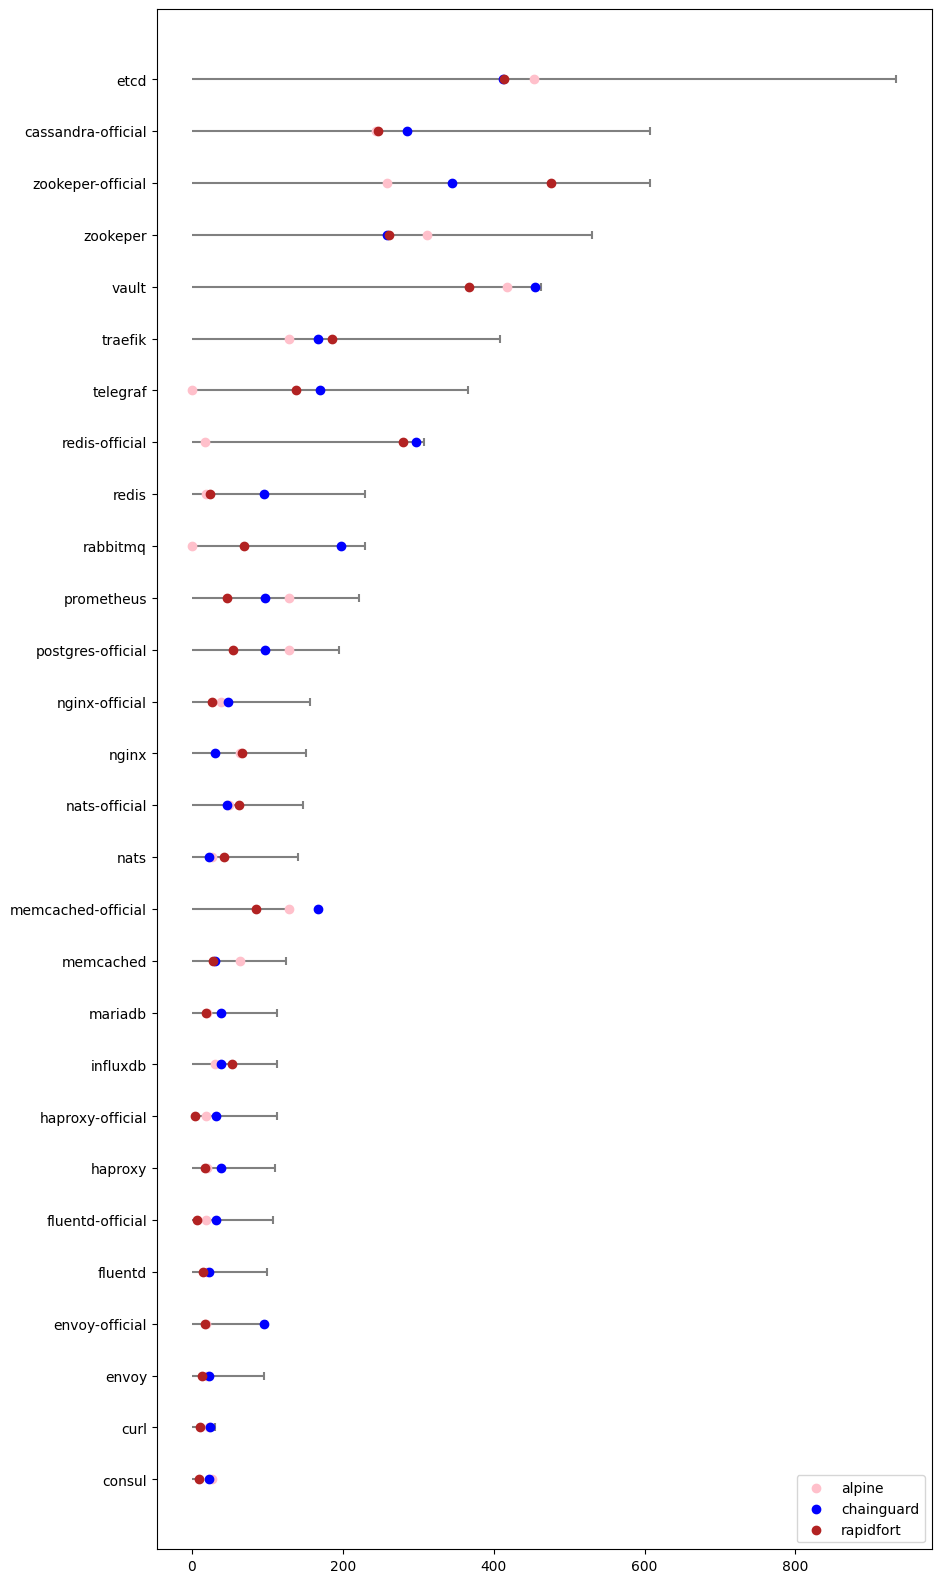

In [99]:
# Figure 2: Number of Components per Image by Registry

comps_df.groupby("registry_type").describe()

alpine = comps_df[comps_df["registry_type"] == "alpine"]["n_components"]
cguard = comps_df[comps_df["registry_type"] == "chainguard"]["n_components"]
rfort = comps_df[comps_df["registry_type"] == "rapidfort"]["n_components"]

comps_df.groupby("registry_type").describe()
plot_df(comps_df, "n_components")

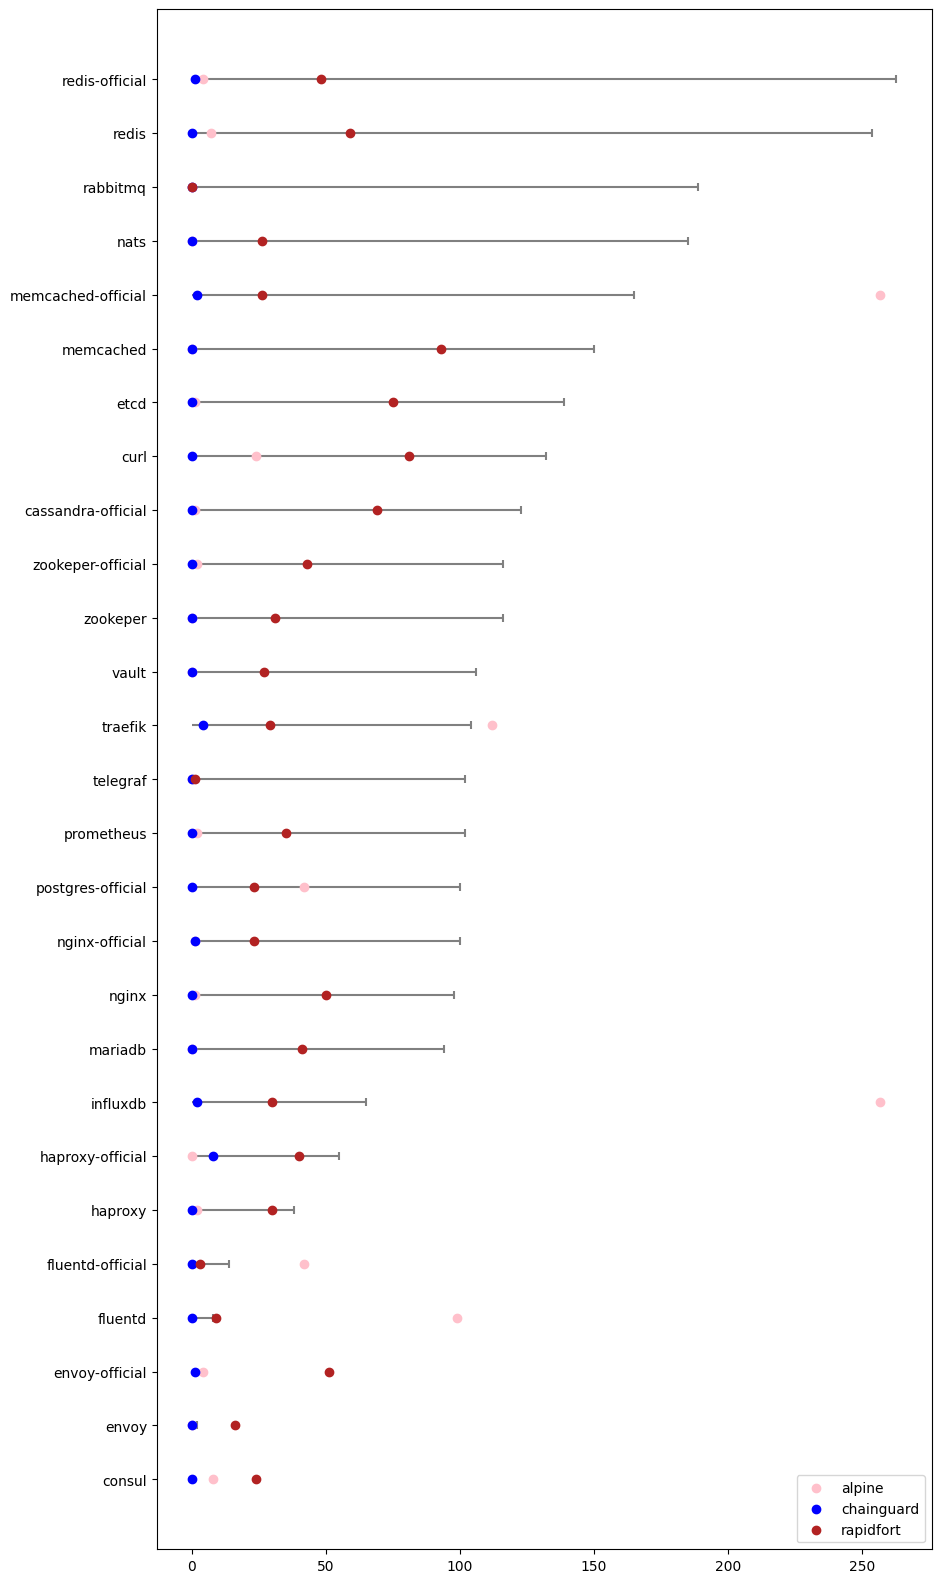

In [97]:
# Figure 3: Number of Vulnerabilities per Image by Registry

# vulns_df.groupby("registry_type").describe()
plot_df(vulns_df, "n_vulns")

In [80]:
# Figure 4: Reduction in Vulnerabilities per Component per Image by Registry

mask = df["registry_type"] == "original"
original_df = df[mask][["image_type", "vpc"]]

reduced_df = df[["image_type", "registry_type", "vpc"]] \
           .merge(original_df, how="left", on="image_type",
                  suffixes=("_reduced", "_original")) \
           .fillna(0)

reduced_df["dvpc"] = reduced_df["vpc_reduced"] - reduced_df["vpc_original"]
# reduced_df = reduced_df.drop(["vpc_reduced", "vpc_original"], axis=1)

reduced_df.groupby("registry_type").describe()
#plot_df(reduced_df, "dvpc")

vpc_reduced                                                    \
                    count      mean       std       min       25%       50%   
registry_type                                                                 
alpine               18.0  0.832074  1.506012  0.002203  0.022478  0.064901   
chainguard            7.0  0.015376  0.013164  0.002421  0.005988  0.011594   
original             26.0  0.622743  0.491023  0.025974  0.240641  0.574478   
rapidfort            26.0  0.833839  0.665455  0.032143  0.252016  0.589855   

                                  vpc_original            ...            \
                    75%       max        count      mean  ...       75%   
registry_type                                             ...             
alpine         1.614387  5.823529         18.0  0.455625  ...  0.773811   
chainguard     0.020619  0.040404          7.0  0.324395  ...  0.488971   
original       0.929204  1.750000         26.0  0.622743  ...  0.929204   
rapidfort      1.488636  2.058824         26.0  0.555435  ...  0.884134   

                         dvpc                                          \
                    max count      mean       std       min       25%   
registry_type                                                           
alpine         1.040816  18.0  0.376449  1.614020 -0.935553 -0.559971   
chainguard     0.743243   7.0 -0.309019  0.269680 -0.722625 -0.475667   
original       1.750000  26.0  0.000000  0.000000  0.000000  0.000000   
rapidfort      1.681818  26.0  0.278404  0.513283 -0.652655 -0.093609   

                                             
                    50%       75%       max  
registry_type                                
alpine        -0.138375  0.890694  5.797555  
chainguard    -0.199771 -0.132193 -0.025020  
original       0.000000  0.000000  0.000000  
rapidfort      0.148529  0.567231  1.390029  

[4 rows x 24 columns]